=== ROBOT REPARTIDOR DE GALLETAS - PROGRAMACIÓN GENÉTICA ===

Configuración del problema:
- Sala: 10x10 celdas (coordenadas enteras)
- Ingenieros: 8 distribuidos aleatoriamente
- Robot inicia en el centro (5,5) con 10 galletas
- Movimiento: 1 celda por vez (norte, sur, este, oeste)
- Entrega: Si está en celda adyacente al ingeniero
- Objetivo: Maximizar galletas entregadas y cobertura

Conjuntos definidos:
Terminales: ['mover_norte', 'mover_sur', 'mover_este', 'mover_oeste', 'entregar_galleta', 'buscar_ingeniero_cercano', 'ir_centro']
Funciones: ['secuencia', 'si_hay_galletas', 'repetir', 'si_ingeniero_cerca']

Iniciando evolución...

Generación 1: Mejor aptitud = 1464.00
Generación 2: Mejor aptitud = 1671.00
Generación 3: Mejor aptitud = 1674.00
Generación 4: Mejor aptitud = 1677.00
Generación 5: Mejor aptitud = 1679.00
Generación 6: Mejor aptitud = 1679.00
Generación 7: Mejor aptitud = 1680.00
Generación 8: Mejor aptitud = 1677.00
Generación 9: Mejor aptitud = 1682.00
Generación 10: 

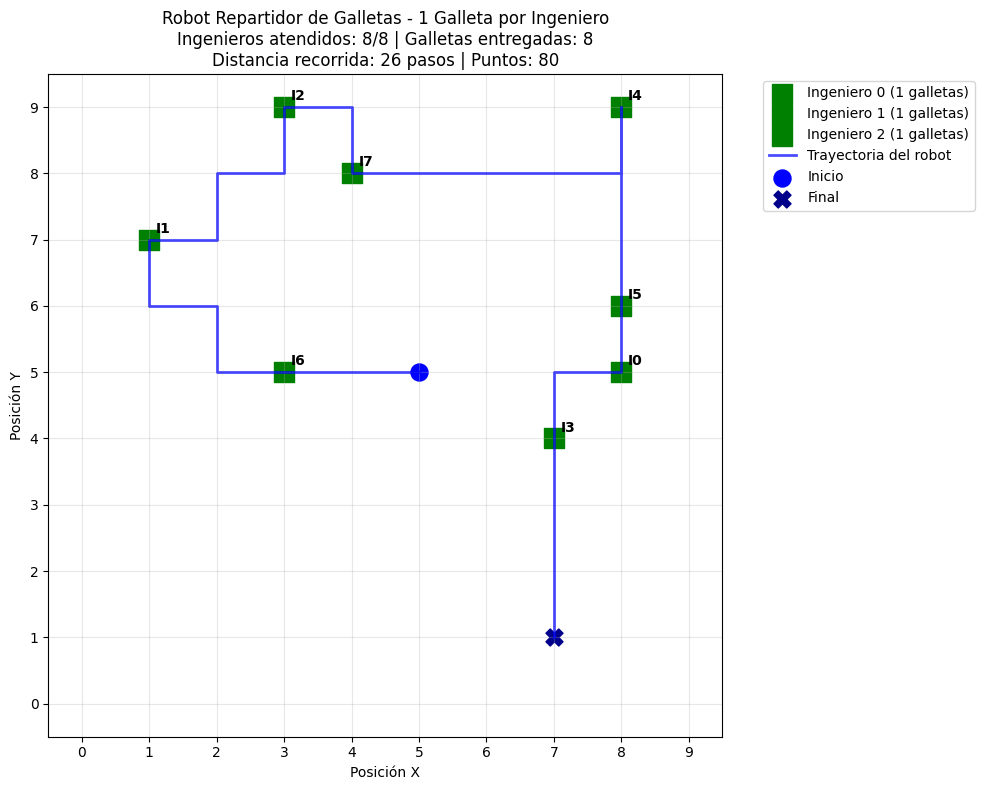

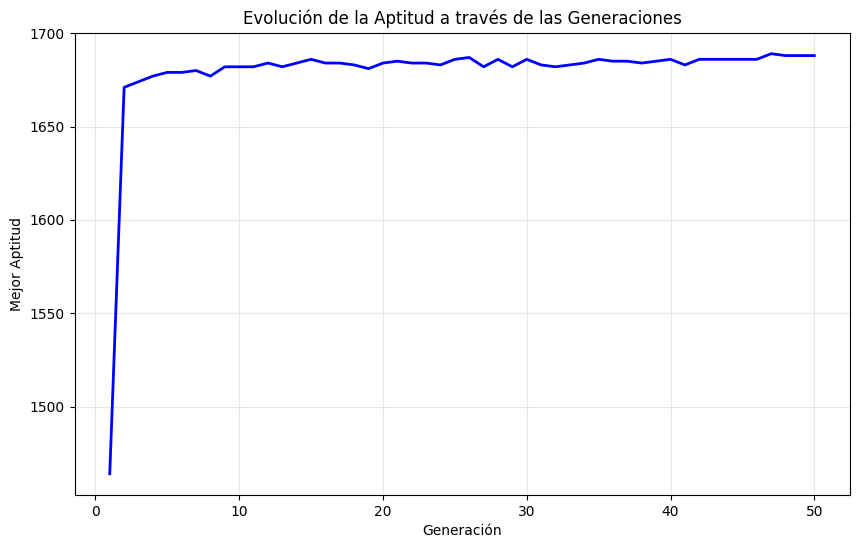

In [25]:
import random
import math
import copy
from typing import List, Tuple, Any
import matplotlib.pyplot as plt
import numpy as np

class Ingeniero:
    """Representa un ingeniero en la sala"""
    def __init__(self, x: int, y: int, id: int):
        self.x = x
        self.y = y
        self.id = id
        self.galletas_recibidas = 0
        self.visitado = False

class Robot:
    """Representa el robot repartidor"""
    def __init__(self, x: int = 5, y: int = 5):
        self.x = x
        self.y = y
        self.galletas = 10  # Número inicial de galletas
        self.puntos = 0
        self.distancia_recorrida = 0
        self.posiciones_visitadas = [(x, y)]

class Nodo:
    """Nodo del árbol de programación genética"""
    def __init__(self, valor, hijos=None):
        self.valor = valor
        self.hijos = hijos if hijos else []
        self.es_terminal = len(self.hijos) == 0

class ProgramacionGenetica:
    """Implementación de Programación Genética para el robot"""

    def __init__(self, sala_size=10, num_ingenieros=8):
        self.sala_size = sala_size
        self.num_ingenieros = num_ingenieros

        # Conjunto de Terminales
        self.terminales = [
            'mover_norte', 'mover_sur', 'mover_este', 'mover_oeste',
            'entregar_galleta', 'buscar_ingeniero_cercano', 'ir_centro'
        ]

        # Conjunto de Funciones
        self.funciones = {
            'secuencia': 2,      # Ejecuta dos acciones en secuencia
            'si_hay_galletas': 2, # If-then-else basado en galletas disponibles
            'repetir': 2,        # Repite una acción n veces
            'si_ingeniero_cerca': 2  # If-then-else basado en proximidad
        }

        # Configuración del algoritmo
        self.tam_poblacion = 300
        self.max_generaciones = 50
        self.prob_mutacion = 0.1
        self.prob_cruce = 0.8
        self.max_profundidad = 6

    def crear_ingenieros(self) -> List[Ingeniero]:
        """Crea ingenieros distribuidos aleatoriamente en la sala con coordenadas enteras"""
        ingenieros = []
        for i in range(self.num_ingenieros):
            x = random.randint(1, self.sala_size - 1)
            y = random.randint(1, self.sala_size - 1)
            ingenieros.append(Ingeniero(x, y, i))
        return ingenieros

    def crear_nodo_aleatorio(self, profundidad=0, metodo='grow'):
        """Crea un nodo aleatorio del árbol"""
        if profundidad >= self.max_profundidad or (metodo == 'grow' and random.random() < 0.3):
            # Crear terminal
            return Nodo(random.choice(self.terminales))
        else:
            # Crear función
            funcion = random.choice(list(self.funciones.keys()))
            num_hijos = self.funciones[funcion]
            hijos = [self.crear_nodo_aleatorio(profundidad + 1, metodo) for _ in range(num_hijos)]
            return Nodo(funcion, hijos)

    def ejecutar_programa(self, nodo: Nodo, robot: Robot, ingenieros: List[Ingeniero], pasos_max=100):
        """Ejecuta el programa genético en el robot"""
        if pasos_max <= 0:
            return

        if nodo.es_terminal:
            self.ejecutar_terminal(nodo.valor, robot, ingenieros)
        else:
            self.ejecutar_funcion(nodo.valor, nodo.hijos, robot, ingenieros, pasos_max)

    def ejecutar_terminal(self, accion: str, robot: Robot, ingenieros: List[Ingeniero]):
        """Ejecuta una acción terminal con coordenadas enteras"""
        if accion == 'mover_norte':
            nueva_y = min(robot.y + 1, self.sala_size - 1)
            robot.distancia_recorrida += abs(nueva_y - robot.y)
            robot.y = nueva_y

        elif accion == 'mover_sur':
            nueva_y = max(robot.y - 1, 0)
            robot.distancia_recorrida += abs(nueva_y - robot.y)
            robot.y = nueva_y

        elif accion == 'mover_este':
            nueva_x = min(robot.x + 1, self.sala_size - 1)
            robot.distancia_recorrida += abs(nueva_x - robot.x)
            robot.x = nueva_x

        elif accion == 'mover_oeste':
            nueva_x = max(robot.x - 1, 0)
            robot.distancia_recorrida += abs(nueva_x - robot.x)
            robot.x = nueva_x

        elif accion == 'entregar_galleta':
            if robot.galletas > 0:
                # Buscar ingeniero en la misma posición o adyacente que NO haya recibido galleta
                for ingeniero in ingenieros:
                    distancia = abs(robot.x - ingeniero.x) + abs(robot.y - ingeniero.y)  # Distancia Manhattan
                    if distancia <= 1 and ingeniero.galletas_recibidas == 0:  # Solo si no ha recibido galleta
                        robot.galletas -= 1
                        ingeniero.galletas_recibidas = 1  # Máximo 1 galleta por ingeniero
                        robot.puntos += 10  # Puntos por entregar galleta
                        break

        elif accion == 'buscar_ingeniero_cercano':
            if ingenieros:
                # Encontrar el ingeniero más cercano que NO haya recibido galleta
                ingenieros_sin_galleta = [ing for ing in ingenieros if ing.galletas_recibidas == 0]

                if ingenieros_sin_galleta:  # Si hay ingenieros que no han recibido galleta
                    distancias = [(abs(robot.x - ing.x) + abs(robot.y - ing.y), ing)
                                for ing in ingenieros_sin_galleta]
                    distancia_min, ingeniero_cercano = min(distancias, key=lambda x: x[0])
                else:
                    # Si todos ya tienen galleta, ir al más cercano de todos
                    distancias = [(abs(robot.x - ing.x) + abs(robot.y - ing.y), ing)
                                for ing in ingenieros]
                    distancia_min, ingeniero_cercano = min(distancias, key=lambda x: x[0])

                # Moverse un paso hacia él
                dx = ingeniero_cercano.x - robot.x
                dy = ingeniero_cercano.y - robot.y

                # Decidir si moverse en X o Y (priorizar la mayor diferencia)
                if abs(dx) >= abs(dy) and dx != 0:
                    if dx > 0:
                        robot.x = min(robot.x + 1, self.sala_size - 1)
                    else:
                        robot.x = max(robot.x - 1, 0)
                    robot.distancia_recorrida += 1
                elif dy != 0:
                    if dy > 0:
                        robot.y = min(robot.y + 1, self.sala_size - 1)
                    else:
                        robot.y = max(robot.y - 1, 0)
                    robot.distancia_recorrida += 1

        elif accion == 'ir_centro':
            centro_x, centro_y = self.sala_size // 2, self.sala_size // 2
            dx = centro_x - robot.x
            dy = centro_y - robot.y

            # Moverse un paso hacia el centro
            if abs(dx) >= abs(dy) and dx != 0:
                if dx > 0:
                    robot.x = min(robot.x + 1, self.sala_size - 1)
                else:
                    robot.x = max(robot.x - 1, 0)
                robot.distancia_recorrida += 1
            elif dy != 0:
                if dy > 0:
                    robot.y = min(robot.y + 1, self.sala_size - 1)
                else:
                    robot.y = max(robot.y - 1, 0)
                robot.distancia_recorrida += 1

        robot.posiciones_visitadas.append((robot.x, robot.y))

    def ejecutar_funcion(self, funcion: str, hijos: List[Nodo], robot: Robot,
                        ingenieros: List[Ingeniero], pasos_max: int):
        """Ejecuta una función no-terminal"""
        if funcion == 'secuencia':
            self.ejecutar_programa(hijos[0], robot, ingenieros, pasos_max - 1)
            self.ejecutar_programa(hijos[1], robot, ingenieros, pasos_max - 1)

        elif funcion == 'si_hay_galletas':
            if robot.galletas > 0:
                self.ejecutar_programa(hijos[0], robot, ingenieros, pasos_max - 1)
            else:
                self.ejecutar_programa(hijos[1], robot, ingenieros, pasos_max - 1)

        elif funcion == 'repetir':
            for _ in range(3):  # Repetir 3 veces
                if pasos_max > 0:
                    self.ejecutar_programa(hijos[0], robot, ingenieros, pasos_max - 1)
                    pasos_max -= 1

        elif funcion == 'si_ingeniero_cerca':
            # Verificar si hay algún ingeniero cerca (distancia Manhattan <= 2)
            ingeniero_cerca = any(
                abs(robot.x - ing.x) + abs(robot.y - ing.y) <= 2
                for ing in ingenieros
            )

            if ingeniero_cerca:
                self.ejecutar_programa(hijos[0], robot, ingenieros, pasos_max - 1)
            else:
                self.ejecutar_programa(hijos[1], robot, ingenieros, pasos_max - 1)

    def funcion_aptitud(self, programa: Nodo) -> float:
        """Función de aptitud que evalúa qué tan bien funciona un programa"""
        # Crear escenario de prueba
        ingenieros = self.crear_ingenieros()
        robot = Robot(self.sala_size // 2, self.sala_size // 2)  # Empezar en el centro

        # Ejecutar programa
        self.ejecutar_programa(programa, robot, ingenieros, pasos_max=100)

        # Calcular aptitud
        galletas_entregadas = sum(min(ing.galletas_recibidas, 1) for ing in ingenieros)  # Máximo 1 por ingeniero
        ingenieros_atendidos = sum(1 for ing in ingenieros if ing.galletas_recibidas > 0)  # Número de ingenieros únicos atendidos
        cobertura = len(set(robot.posiciones_visitadas))  # Posiciones únicas visitadas

        # Función de aptitud multiobjetivo mejorada
        aptitud = (
            ingenieros_atendidos * 120 +         # Priorizar atender más ingenieros únicos
            galletas_entregadas * 80 +           # Recompensa por galletas entregadas
            cobertura * 2 +                      # Recompensa por explorar
            max(0, 50 - robot.distancia_recorrida)  # Penalización por distancia excesiva
        )

        return max(0, aptitud)

    def torneo_seleccion(self, poblacion: List[Tuple[Nodo, float]], k=3) -> Nodo:
        """Selección por torneo"""
        torneo = random.sample(poblacion, min(k, len(poblacion)))
        return max(torneo, key=lambda x: x[1])[0]

    def cruzar(self, padre1: Nodo, padre2: Nodo) -> Tuple[Nodo, Nodo]:
        """Cruzamiento de dos programas"""
        hijo1 = copy.deepcopy(padre1)
        hijo2 = copy.deepcopy(padre2)

        # Seleccionar puntos de cruce aleatorios
        nodos1 = self.obtener_nodos(hijo1)
        nodos2 = self.obtener_nodos(hijo2)

        if len(nodos1) > 1 and len(nodos2) > 1:
            punto1 = random.choice(nodos1[1:])  # Evitar la raíz
            punto2 = random.choice(nodos2[1:])

            # Intercambiar subárboles
            punto1.valor, punto2.valor = punto2.valor, punto1.valor
            punto1.hijos, punto2.hijos = punto2.hijos, punto1.hijos

        return hijo1, hijo2

    def obtener_nodos(self, nodo: Nodo) -> List[Nodo]:
        """Obtiene todos los nodos del árbol"""
        nodos = [nodo]
        for hijo in nodo.hijos:
            nodos.extend(self.obtener_nodos(hijo))
        return nodos

    def mutar(self, programa: Nodo) -> Nodo:
        """Mutación de un programa"""
        programa_mutado = copy.deepcopy(programa)
        nodos = self.obtener_nodos(programa_mutado)

        if nodos:
            nodo_a_mutar = random.choice(nodos)
            if nodo_a_mutar.es_terminal:
                nodo_a_mutar.valor = random.choice(self.terminales)
            else:
                nueva_funcion = random.choice(list(self.funciones.keys()))
                if self.funciones[nueva_funcion] == len(nodo_a_mutar.hijos):
                    nodo_a_mutar.valor = nueva_funcion

        return programa_mutado

    def evolucionar(self):
        """Algoritmo genético principal"""
        # Inicializar población
        poblacion = []
        for _ in range(self.tam_poblacion):
            programa = self.crear_nodo_aleatorio(metodo='ramped-half-and-half')
            poblacion.append(programa)

        mejor_aptitud_por_gen = []
        mejor_programa = None
        mejor_aptitud = 0

        for generacion in range(self.max_generaciones):
            # Evaluar aptitud
            aptitudes = [(prog, self.funcion_aptitud(prog)) for prog in poblacion]

            # Encontrar mejor de esta generación
            mejor_gen = max(aptitudes, key=lambda x: x[1])
            if mejor_gen[1] > mejor_aptitud:
                mejor_aptitud = mejor_gen[1]
                mejor_programa = copy.deepcopy(mejor_gen[0])

            mejor_aptitud_por_gen.append(mejor_gen[1])

            print(f"Generación {generacion + 1}: Mejor aptitud = {mejor_gen[1]:.2f}")

            # Crear nueva población
            nueva_poblacion = []

            # Elitismo: mantener los mejores
            aptitudes.sort(key=lambda x: x[1], reverse=True)
            for i in range(min(5, len(aptitudes))):
                nueva_poblacion.append(copy.deepcopy(aptitudes[i][0]))

            # Generar el resto por cruzamiento y mutación
            while len(nueva_poblacion) < self.tam_poblacion:
                if random.random() < self.prob_cruce:
                    padre1 = self.torneo_seleccion(aptitudes)
                    padre2 = self.torneo_seleccion(aptitudes)
                    hijo1, hijo2 = self.cruzar(padre1, padre2)

                    if random.random() < self.prob_mutacion:
                        hijo1 = self.mutar(hijo1)
                    if random.random() < self.prob_mutacion:
                        hijo2 = self.mutar(hijo2)

                    nueva_poblacion.extend([hijo1, hijo2])
                else:
                    padre = self.torneo_seleccion(aptitudes)
                    hijo = self.mutar(copy.deepcopy(padre))
                    nueva_poblacion.append(hijo)

            poblacion = nueva_poblacion[:self.tam_poblacion]

        return mejor_programa, mejor_aptitud, mejor_aptitud_por_gen

    def imprimir_programa(self, nodo: Nodo, nivel=0):
        """Imprime el programa de forma legible"""
        indent = "  " * nivel
        print(f"{indent}{nodo.valor}")
        for hijo in nodo.hijos:
            self.imprimir_programa(hijo, nivel + 1)

    def visualizar_ejecucion(self, programa: Nodo):
        """Visualiza la ejecución del mejor programa"""
        ingenieros = self.crear_ingenieros()
        robot = Robot(self.sala_size // 2, self.sala_size // 2)

        # Ejecutar programa
        self.ejecutar_programa(programa, robot, ingenieros, pasos_max=100)

        # Crear visualización
        plt.figure(figsize=(10, 8))

        # Dibujar cuadrícula
        plt.xlim(-0.5, self.sala_size - 0.5)
        plt.ylim(-0.5, self.sala_size - 0.5)
        plt.grid(True, alpha=0.3)

        # Configurar ticks para mostrar coordenadas enteras
        plt.xticks(range(self.sala_size))
        plt.yticks(range(self.sala_size))

        # Dibujar ingenieros
        for i, ing in enumerate(ingenieros):
            color = 'green' if ing.galletas_recibidas > 0 else 'red'
            plt.scatter(ing.x, ing.y, c=color, s=200, marker='s',
                       label=f'Ingeniero {i} ({ing.galletas_recibidas} galletas)' if i < 3 else "")
            plt.annotate(f'I{i}', (ing.x, ing.y), xytext=(5, 5),
                        textcoords='offset points', fontsize=10, fontweight='bold')

        # Dibujar trayectoria del robot
        if robot.posiciones_visitadas:
            x_pos = [pos[0] for pos in robot.posiciones_visitadas]
            y_pos = [pos[1] for pos in robot.posiciones_visitadas]
            plt.plot(x_pos, y_pos, 'b-', alpha=0.7, linewidth=2, label='Trayectoria del robot')
            plt.scatter(x_pos[0], y_pos[0], c='blue', s=150, marker='o', label='Inicio')
            plt.scatter(x_pos[-1], y_pos[-1], c='darkblue', s=150, marker='X', label='Final')

        ingenieros_atendidos = sum(1 for ing in ingenieros if ing.galletas_recibidas > 0)
        plt.title(f'Robot Repartidor de Galletas - 1 Galleta por Ingeniero\n'
                 f'Ingenieros atendidos: {ingenieros_atendidos}/{len(ingenieros)} | '
                 f'Galletas entregadas: {sum(ing.galletas_recibidas for ing in ingenieros)}\n'
                 f'Distancia recorrida: {robot.distancia_recorrida} pasos | Puntos: {robot.puntos}')
        plt.xlabel('Posición X')
        plt.ylabel('Posición Y')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    print("=== ROBOT REPARTIDOR DE GALLETAS - PROGRAMACIÓN GENÉTICA ===\n")

    print("Configuración del problema:")
    print("- Sala: 10x10 celdas (coordenadas enteras)")
    print("- Ingenieros: 8 distribuidos aleatoriamente")
    print("- Robot inicia en el centro (5,5) con 10 galletas")
    print("- Movimiento: 1 celda por vez (norte, sur, este, oeste)")
    print("- Entrega: Si está en celda adyacente al ingeniero")
    print("- Objetivo: Maximizar galletas entregadas y cobertura\n")

    print("Conjuntos definidos:")
    pg = ProgramacionGenetica()
    print(f"Terminales: {pg.terminales}")
    print(f"Funciones: {list(pg.funciones.keys())}\n")

    print("Iniciando evolución...\n")

    # Ejecutar algoritmo genético
    mejor_programa, mejor_aptitud, historial = pg.evolucionar()

    print(f"\n=== RESULTADOS ===")
    print(f"Mejor aptitud final: {mejor_aptitud:.2f}")
    print(f"\nMejor programa encontrado:")
    pg.imprimir_programa(mejor_programa)

    print(f"\nVisualizando ejecución del mejor programa...")
    pg.visualizar_ejecucion(mejor_programa)

    # Gráfico de evolución
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(historial) + 1), historial, 'b-', linewidth=2)
    plt.title('Evolución de la Aptitud a través de las Generaciones')
    plt.xlabel('Generación')
    plt.ylabel('Mejor Aptitud')
    plt.grid(True, alpha=0.3)
    plt.show()